In [28]:
# Import core libraries for data manipulation, visualization, modeling, and saving models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
import joblib

In [18]:
# Load preprocessed data saved from the first notebook
df = pd.read_csv(r"C:\Users\nimak\Documents\Projects\bank-marketing-classification\data\bank_marketing_processed.csv")

# Separate features and target
X = df.drop('y', axis=1)   # Features
y = df['y']                # Target variable

# Split the data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (32950, 63), Test shape: (8238, 63)


In [20]:
# Load the best model (Gradient Boosting from notebook 2)
model = joblib.load('best_model_gradient_boosting.pkl')

# Extract feature importances directly from the trained Gradient Boosting model
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame to organize and sort features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print selected features
#selected_features = X_train.columns[rfe.support_]
#print(f"Selected features after RFE: {selected_features}")

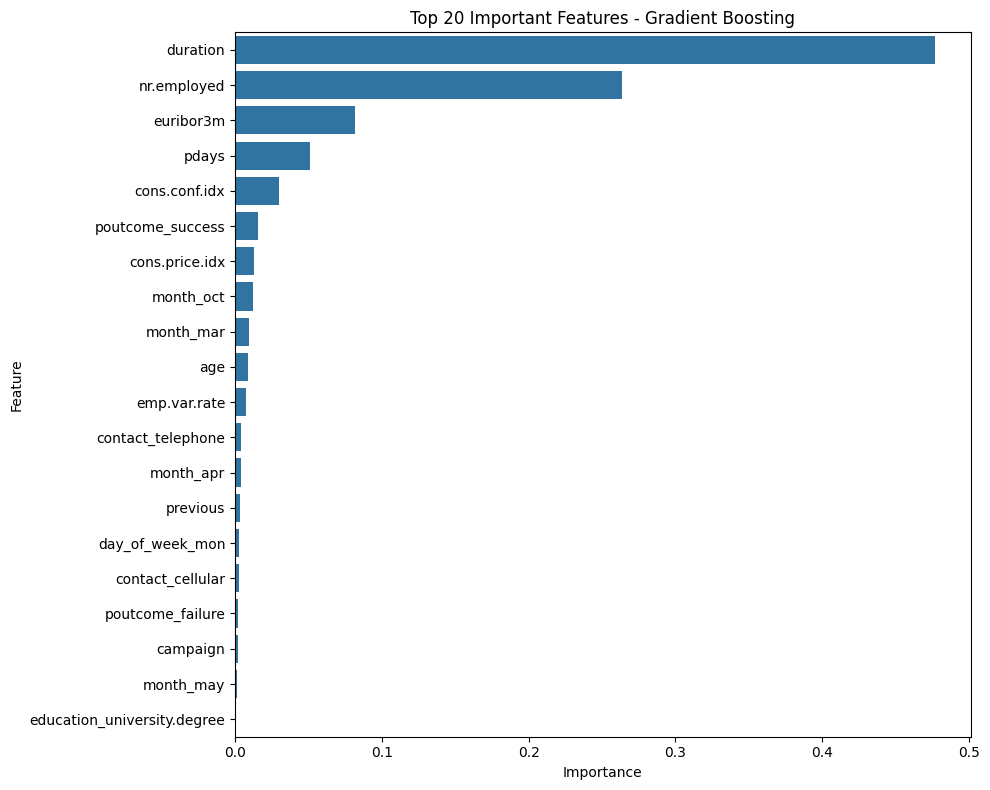

In [22]:
# Plot the top 20 most important features based on their calculated importance scores
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Important Features - Gradient Boosting')
plt.tight_layout()
plt.show()

In [23]:
# Keep only the features whose importance is above a set threshold (e.g., 0.01)
threshold = 0.01
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

print(f"Number of features before selection: {X.shape[1]}")
print(f"Number of features after selection: {len(selected_features)}")

Number of features before selection: 63
Number of features after selection: 8


In [24]:
# Retrain the Gradient Boosting model using only the most important features
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

reduced_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
reduced_model.fit(X_train_reduced, y_train)

# Predict and evaluate the reduced model
y_pred_reduced = reduced_model.predict(X_test_reduced)

print("\nClassification Report (Reduced Features):")
print(classification_report(y_test, y_pred_reduced))


Classification Report (Reduced Features):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7310
           1       0.70      0.56      0.62       928

    accuracy                           0.92      8238
   macro avg       0.82      0.76      0.79      8238
weighted avg       0.92      0.92      0.92      8238



In [25]:
# Evaluate and compare the original full model's performance
y_pred_full = model.predict(X_test)

print("\nClassification Report (Full Features):")
print(classification_report(y_test, y_pred_full))


Classification Report (Full Features):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.70      0.54      0.61       928

    accuracy                           0.92      8238
   macro avg       0.82      0.76      0.78      8238
weighted avg       0.92      0.92      0.92      8238



In [26]:
# Save the retrained model that used only selected important features
joblib.dump(reduced_model, 'reduced_model_gradient_boosting.pkl')

['reduced_model_gradient_boosting.pkl']

In [29]:
# Full feature training
start = time.time()
model.fit(X_train, y_train)
end = time.time()
print("⏱ Full feature training time:", round(end - start, 2), "seconds")

# Reduced feature training
start = time.time()
reduced_model.fit(X_train_reduced, y_train)
end = time.time()
print("⏱ Reduced feature training time:", round(end - start, 2), "seconds")

⏱ Full feature training time: 4.4 seconds
⏱ Reduced feature training time: 1.37 seconds
